In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import numpy as np

# Q网络定义
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# 经验回放池
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))
        return (
            torch.tensor(np.stack(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.stack(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
        )

    def size(self):
        return len(self.buffer)


In [2]:
import matplotlib.pyplot as plt

def plot_dataList(rewards, xStart=0):
    # 设置图像的宽度为 12 英寸
    plt.figure(figsize=(12, 6))
    
    plt.plot(range(xStart, len(rewards) + xStart), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward vs Episode')
    plt.show()


In [3]:
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DuelingDQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
        )
        self.V = nn.Linear(128, 1)
        self.A = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q

In [4]:
import numpy as np

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha

    def add(self, state, action, reward, next_state, done):
        """添加新经验，优先级初始化为最大值以确保被采样"""
        max_priority = self.priorities.max() if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        """
        采样带优先级的批次数据
        beta: 重要性采样的偏置修正参数
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        
        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones = zip(*samples)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32),
            torch.tensor(actions, dtype=torch.int64),
            torch.tensor(rewards, dtype=torch.float32),
            torch.tensor(np.stack(next_states), dtype=torch.float32),
            torch.tensor(dones, dtype=torch.float32),
            torch.tensor(weights, dtype=torch.float32),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities
    
    def size(self):
        return len(self.buffer)

In [5]:
import torch
import torch.nn as nn

class NoisyLinear(nn.Module):
    def __init__(self, in_features, out_features, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        # 可训练参数
        self.weight_mu = nn.Parameter(torch.empty(out_features, in_features))
        self.weight_sigma = nn.Parameter(torch.empty(out_features, in_features))
        self.bias_mu = nn.Parameter(torch.empty(out_features))
        self.bias_sigma = nn.Parameter(torch.empty(out_features))

        # 非参数化噪声
        self.register_buffer("weight_epsilon", torch.empty(out_features, in_features))
        self.register_buffer("bias_epsilon", torch.empty(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        # 初始化可训练参数
        bound = 1 / self.in_features ** 0.5
        self.weight_mu.data.uniform_(-bound, bound)
        self.weight_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))
        self.bias_mu.data.uniform_(-bound, bound)
        self.bias_sigma.data.fill_(self.std_init / (self.in_features ** 0.5))

    def reset_noise(self):
        # 采样噪声
        self.weight_epsilon.normal_()
        self.bias_epsilon.normal_()

    def forward(self, x):
        if self.training:
            weight = self.weight_mu + self.weight_sigma * self.weight_epsilon
            bias = self.bias_mu + self.bias_sigma * self.bias_epsilon
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return torch.nn.functional.linear(x, weight, bias)

class Dueling_NoisyDQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Dueling_NoisyDQN, self).__init__()
        self.fc = nn.Sequential(
            NoisyLinear(input_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, 128),
            nn.ReLU(),
        )
        self.V = NoisyLinear(128, 1)
        self.A = NoisyLinear(128, output_dim)

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x)
        A = self.A(x)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        return Q
    
    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

In [6]:
class MultiStepPrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, n_step=3, gamma=0.99):
        """
        capacity: 缓冲区容量
        alpha: 优先级比例，0表示完全随机采样，1表示完全按优先级采样
        n_step: 多步时间跨度
        gamma: 折扣因子
        """
        self.capacity = capacity
        self.buffer = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0
        self.alpha = alpha
        self.n_step = n_step
        self.gamma = gamma

        # 用于多步存储的临时队列
        self.n_step_queue = []

    def _get_n_step_info(self):
        """从 n_step_queue 计算 n 步累计奖励和目标状态"""
        R = 0
        # 实际队列长度可能小于 n_step
        n_step = len(self.n_step_queue)
        for idx, (_, _, reward, _, _) in enumerate(self.n_step_queue):
            R += (self.gamma ** idx) * reward
        state, action, _, next_state, done = self.n_step_queue[0]
        final_next_state, final_done = self.n_step_queue[-1][3], self.n_step_queue[-1][4]
        return (state, action, R, final_next_state, final_done, n_step)

    def add(self, state, action, reward, next_state, done):
        """
        添加新经验。
        使用 n_step_queue 缓存多步数据，只有在积累到 n 步时才存入 buffer。
        在轨迹结束时处理剩余的队列。
        """
        self.n_step_queue.append((state, action, reward, next_state, done))
        
        # 如果 n_step_queue 满了，处理一个完整的 n-step 转移
        if len(self.n_step_queue) == self.n_step:
            n_step_transition = self._get_n_step_info()
            max_priority = self.priorities.max() if self.buffer else 1.0
            if len(self.buffer) < self.capacity:
                self.buffer.append(n_step_transition)
            else:
                self.buffer[self.position] = n_step_transition
            self.priorities[self.position] = max_priority
            self.position = (self.position + 1) % self.capacity

            # 移除队列的第一个元素
            self.n_step_queue.pop(0)

        # 如果 done=True，处理剩余队列中的短步转移
        if done:
            while self.n_step_queue:
                n_step_transition = self._get_n_step_info()
                max_priority = self.priorities.max() if self.buffer else 1.0
                if len(self.buffer) < self.capacity:
                    self.buffer.append(n_step_transition)
                else:
                    self.buffer[self.position] = n_step_transition
                self.priorities[self.position] = max_priority
                self.position = (self.position + 1) % self.capacity

                # 移除队列的第一个元素
                self.n_step_queue.pop(0)

    def sample(self, batch_size, beta=0.4, device='cpu'):
        """
        采样带优先级的批次数据。
        """
        if len(self.buffer) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]

        # 根据优先级分布计算采样概率
        probs = priorities ** self.alpha
        probs /= probs.sum()

        # 按照概率采样
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [self.buffer[idx] for idx in indices]

        # 计算重要性采样权重
        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()

        # 解包样本
        states, actions, rewards, next_states, dones, n_steps = zip(*samples)
        return (
            torch.tensor(np.stack(states), dtype=torch.float32).to(device),
            torch.tensor(actions, dtype=torch.int64).to(device),
            torch.tensor(rewards, dtype=torch.float32).to(device),
            torch.tensor(np.stack(next_states), dtype=torch.float32).to(device),
            torch.tensor(dones, dtype=torch.float32).to(device),
            torch.tensor(weights, dtype=torch.float32).to(device),
            torch.tensor(n_steps, dtype=torch.int64).to(device),
            indices,
        )

    def update_priorities(self, indices, priorities):
        """根据新的 TD Error 更新优先级"""
        self.priorities[indices] = priorities

    def size(self):
        return len(self.buffer)
    
    def current_queue_size(self):
        return len(self.n_step_queue)

In [7]:
import os
import time
import pygame
import csv
from datetime import datetime
import configparser

fileName = 'models/fb_v0_no_score_2024-12-10_21-45-31.pth'
bestScoreFileName = 'flappy_bird_v0_model_best_score.pth'
stopTrainingFileName = 'flappy_bird_stop.txt'
guideFileName = 'result1/models/fb_v0_no_score_2024-12-07_16-37-46.pth'

def train_dueling_dqn_noise_MultiStep_PER(env, num_episodes=500, batch_size=64, gamma=0.99, 
                                          epsilon_schedule=[(0, 1.0), (20000, 0.1), (700000, 0.01), (1040000, 0.001), (1720000, 0.0001), (2060000, 0.0)], 
                                          lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4,
                                          modelFile = None):
    # 新的状态维度为原始状态维度的 12 倍
    number_of_states = 12
    input_dim = env.observation_space.shape[0] * number_of_states
    output_dim = env.action_space.n

    # 检查是否有GPU可用
    device = torch.device("cpu")
    print("Using device:", device)

    q_net = Dueling_NoisyDQN(input_dim, output_dim).to(device)
    # 判断是否存在modelFile文件
    if modelFile and os.path.exists(modelFile):
        q_net.load_state_dict(torch.load(modelFile, weights_only=True, map_location=device))
        print("模型已加载")
    q_net.train() # 设置为训练模式，需要通过训练更新参数，该行代码可以省略，因为默认就是训练模式
    target_net = Dueling_NoisyDQN(input_dim, output_dim).to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval() # 设置为评估模式，不需要通过训练更新参数，更新时只需要复制q_net的参数
    guider_net = Dueling_NoisyDQN(env.observation_space.shape[0], output_dim)
    guideOpen = False
    if os.path.exists(guideFileName):
        guider_net.load_state_dict(torch.load(guideFileName, weights_only=True))
        guider_net = guider_net.to(device)
        guider_net.eval()
        print("引导模型已加载")
    else:
        guider_net = None

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer_capacity = 100000
    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=replay_buffer_capacity, alpha=alpha, n_step=40, gamma=gamma)
    epsilon = epsilon_schedule[0][1]
    beta = beta_start
    rewards = []  # 确保它是一个列表
    max_reward_total = -np.inf
    max_interval_rewards = -np.inf
    min_interval_rewards = np.inf
    max_score = 0
    score_nearest = deque(maxlen=5)
    max_step_count = 0
    update_step_count = 0
    update_step_interval = 200
    print_interval = 300  # 间隔（单位：秒）
    # 记录训练开始的时间
    last_save_time = time.time()
    last_print_time = last_save_time
    stop_training = False
    steps_Interval = 1000
    steps_perInterval = 0
    steps_total = 0
    loss_perInterval = 0
    q_value_perInterval = 0
    # 获取当前时间戳
    current_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    csv_file = f'dueling_dqn_noise_MultiStep_PER_{current_time_str}.csv'
    aim_score = 5000

    # 创建表格文件，列名分别为：总步数、epsilon、平均损失、平均Q值
    with open(csv_file, 'w') as f:
        f.write('Time,episode,Steps,epsilon,loss,Q_value,max_reward_total,max_score,max_score_nearest,min_score_nearest,avg_score_nearest,max_reward_nearest,min_reward_nearest,avg_reward_nearest\n')
        f.close()
    ratio_schedule = []
    for i in range(len(epsilon_schedule) - 1):
        start_step, start_epsilon = epsilon_schedule[i]
        end_step, end_epsilon = epsilon_schedule[i + 1]
        ratio = (end_epsilon - start_epsilon) / (end_step - start_step)
        ratio_schedule.append(ratio)
    
    print(f"Episode | min interval reward | max interval reward | max_reward_total | Epsilon | max_score | steps_total | lr | update_step_interval | beta | replay_buffer.size")
    for episode in range(num_episodes):
        raw_state = env.reset()  # 返回 numpy.ndarray
        state_queue = deque([raw_state.copy() for _ in range(number_of_states)], maxlen=number_of_states)  # 初始化队列，初始状态填充队列
        state = np.concatenate(state_queue) # 将队列内容展平
        total_reward = 0
        done = False
        step_count = 0
        score = 0

        while not done:  # 每个 episode 的最大步数
            # 根据多段线性衰减策略计算 epsilon
            for i in range(len(epsilon_schedule) - 1):
                start_step, start_epsilon = epsilon_schedule[i]
                end_step, end_epsilon = epsilon_schedule[i + 1]
                if start_step <= steps_total < end_step:
                    # 在当前阶段内进行线性插值
                    ratio = ratio_schedule[i]
                    epsilon = max(start_epsilon + ratio * (steps_total - start_step), end_epsilon)
                elif steps_total >= end_step and i == len(epsilon_schedule) - 2:
                    epsilon = end_epsilon
            # ε-贪婪策略
            if random.random() < epsilon:
                # 根据概率决定采样
                if random.random() < 0.08:
                    action = 1
                else:
                    action = 0
            else:
                with torch.no_grad():
                    if guideOpen and guider_net is not None:
                        action = guider_net(torch.tensor(raw_state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()
                    else:
                        action = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)).argmax().item()

            # 执行动作
            next_raw_state, reward, done, info = env.step(action)
            step_count += 1
            steps_total += 1
            if max_step_count < step_count:
                max_step_count = step_count
            raw_state = next_raw_state
            # 限制高度
            if raw_state[1] > 0.5:
                done = True
            # 更新状态队列
            state_queue.append(next_raw_state)
            next_state = np.concatenate(state_queue)  # 将队列内容展平
            reward = reward * 0.1  # 缩放奖励
            if info['score'] > score:
                #reward += 1  # 奖励增加
                score = info['score']
            if info['score'] > max_score:
                max_score = info['score']
                if max_score > 100:
                    torch.save(q_net.state_dict(), bestScoreFileName) # 保存模型
                env.render()
                time.sleep(1 / 60)  # FPS
                for event in pygame.event.get():
                    pass
            '''if done:
                reward -= 0.2  # 惩罚'''
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if total_reward > max_reward_total:
                max_reward_total = total_reward
            if max_interval_rewards < total_reward:
                max_interval_rewards = total_reward

            # 经验回放训练
            if replay_buffer.size() >= replay_buffer_capacity * 0.1:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, n_step_batch, indices = replay_buffer.sample(batch_size, beta, device)

                q_values = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    q_value_perInterval += q_values.mean().item() / steps_Interval
                    best_actions = q_net(next_states).argmax(1)  # 使用当前网络选择最大Q值的动作
                    target_q_values = rewards_batch + (gamma ** n_step_batch) * (1 - dones) * target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                # 计算 TD Error
                td_errors = target_q_values - q_values
                loss = (weights * td_errors.pow(2)).mean()
                loss_perInterval += loss.item() / steps_Interval

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)
                update_step_count += 1
                steps_perInterval += 1
            
                # 更新目标网络
                if update_step_count >= update_step_interval:
                    update_step_count = 0
                    target_net.load_state_dict(q_net.state_dict()) # 将q_net的参数复制到target_net中
                if steps_perInterval >= steps_Interval:
                    # 计算rewards的最近5个数据的最大、最小、平均值
                    max_reward_nearest = max(rewards[len(rewards) - 5:]) if len(rewards) >= 5 else max(rewards) if len(rewards) > 0 else 0
                    min_reward_nearest = min(rewards[len(rewards) - 5:]) if len(rewards) >= 5 else min(rewards) if len(rewards) > 0 else 0
                    avg_reward_nearest = sum(rewards[len(rewards) - 5:]) / 5 if len(rewards) >= 5 else sum(rewards) / len(rewards) if len(rewards) > 0 else 0
                    # 计算score_nearest的最大、最小、平均值
                    score_nearest_arr = np.array(score_nearest)
                    max_score_nearest = score_nearest_arr.max() if len(score_nearest_arr) > 0 else 0
                    min_score_nearest = score_nearest_arr.min() if len(score_nearest_arr) > 0 else 0
                    avg_score_nearest = score_nearest_arr.mean() if len(score_nearest_arr) > 0 else 0
                    # 追加数据到 CSV 文件
                    with open(csv_file, 'a') as f:
                        current_time_str = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                        f.write(f'{current_time_str},{episode},{steps_total},{epsilon},{loss_perInterval},{q_value_perInterval},{max_reward_total},{max_score},{max_score_nearest},{min_score_nearest},{avg_score_nearest},{max_reward_nearest},{min_reward_nearest},{avg_reward_nearest}\n')
                    steps_perInterval = 0
                    loss_perInterval = 0
                    q_value_perInterval = 0
                # 检查时间间隔
                current_time = time.time()
                if current_time - last_save_time > 60:
                    # 读取配置文件
                    config = configparser.ConfigParser()
                    if config.read('config.ini'):
                        update_step_interval = config.getint('Training', 'update_step_interval')
                        lr_temp = config.getfloat('Training', 'lr')
                        if lr_temp > 0:
                            lr = lr_temp
                            state_dict = optimizer.state_dict()
                            state_dict['param_groups'][0]['lr'] = lr
                            optimizer.load_state_dict(state_dict)
                        beta_temp = config.getfloat('Training', 'beta')
                        if beta_temp > 0:
                            beta = beta_temp
                        stop_training = config.getboolean('Training', 'stop_training')
                        guideOpen = config.getboolean('Training', 'guideOpen')
                        batch_size = config.getint('Training', 'batch_size')
                        
                    # 设置保存路径和合法文件名
                    save_path = "./models"
                    os.makedirs(save_path, exist_ok=True)  # 确保路径存在
                    current_time_str = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')  # 使用合法字符
                    currentNetFile = os.path.join(save_path, f'fb_v0_{current_time_str}.pth')
                    torch.save(q_net.state_dict(), currentNetFile) # 保存模型
                    last_save_time = current_time
                if current_time - last_print_time >= print_interval:
                    last_print_time = current_time
                    print(f"{episode} | {min_interval_rewards:.3f} | {max_interval_rewards:.3f} | {max_reward_total:.3f} | {epsilon:.5f} | {max_score} | {steps_total} | {lr:.8e} | {update_step_interval} | {beta:.5f} | {replay_buffer.size()}")
                    min_interval_rewards = np.inf
                    max_interval_rewards = -np.inf
                # 更新 beta
                beta = min(1.0, beta + beta_increment)

        rewards.append(total_reward)  # 确保 append 正常工作
        if min_interval_rewards > total_reward:
            min_interval_rewards = total_reward
        score_nearest.append(score)
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()
        if stop_training:
            # 把配置文件的stop_training改为False
            config['Training']['stop_training'] = 'False'
            with open('config.ini', 'w') as configfile:
                config.write(configfile)
            break

    return q_net, rewards

pygame 2.0.3 (SDL 2.0.16, Python 3.8.20)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

class Dueling_DistributionalDQN(nn.Module):
    def __init__(self, input_dim, output_dim, num_atoms=51):
        super(Dueling_DistributionalDQN, self).__init__()
        self.fc = nn.Sequential(
            NoisyLinear(input_dim, 128),
            nn.ReLU(),
            NoisyLinear(128, 128),
            nn.ReLU(),
        )
        self.V = NoisyLinear(128, num_atoms)
        self.A = NoisyLinear(128, output_dim * num_atoms)
        self.num_atoms = num_atoms
        self.output_dim = output_dim

    def forward(self, x):
        x = self.fc(x)
        V = self.V(x).view(-1, 1, self.num_atoms)
        A = self.A(x).view(-1, self.output_dim, self.num_atoms)
        Q = V + (A - A.mean(dim=1, keepdim=True))
        Q_prob = F.softmax(Q, dim=2) # 将 Q 值转换为概率分布
        return Q_prob

    def reset_noise(self):
        for m in self.modules():
            if isinstance(m, NoisyLinear):
                m.reset_noise()

def projection_distribution(next_dist, rewards, dones, gamma, atoms, v_min, v_max, delta_z, support):
    """
    投影 Bellman 更新后的分布到支持点。
    """
    #delta_z = (v_max - v_min) / (atoms - 1)
    #support = torch.linspace(v_min, v_max, atoms).to(next_dist.device)  # Shape: (atoms,)
    
    batch_size = rewards.size(0)
    next_support = rewards.unsqueeze(1) + gamma * support.unsqueeze(0) * (1 - dones.unsqueeze(1))  # Shape: (batch_size, atoms)
    next_support = next_support.clamp(v_min, v_max)  # 限制范围

    b = (next_support - v_min) / delta_z  # Shape: (batch_size, atoms)
    l = b.floor().long()  # Shape: (batch_size, atoms)
    u = b.ceil().long()  # Shape: (batch_size, atoms)
    
    # 修正索引的范围，确保不越界
    l = l.clamp(0, atoms - 1)
    u = u.clamp(0, atoms - 1)
    
    proj_dist = torch.zeros(batch_size, atoms).to(next_dist.device)  # Shape: (batch_size, atoms)

    for i in range(atoms):  # 遍历每个支持点
        # 注意：next_dist[:, i] 实际是 batch_size 的第 i 列 (shape: [batch_size])
        # next_dist 应被广播以匹配 l 和 u 的维度
        weight_left = (u[:, i] - b[:, i]).unsqueeze(1)  # Shape: (batch_size, 1)
        weight_right = (b[:, i] - l[:, i]).unsqueeze(1)  # Shape: (batch_size, 1)
        
        proj_dist.scatter_add_(1, l[:, i].unsqueeze(1), next_dist[:, i].unsqueeze(1) * weight_left)
        proj_dist.scatter_add_(1, u[:, i].unsqueeze(1), next_dist[:, i].unsqueeze(1) * weight_right)

    # 归一化分布
    proj_dist /= proj_dist.sum(dim=1, keepdim=True) + 1e-8  # 防止除零
    return proj_dist

def train_rainbow_dqn(env, num_episodes=500, batch_size=64, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01,
                      epsilon_decay=500, lr=1e-3, alpha=0.6, beta_start=0.4, beta_increment=1e-4,
                      atoms=51, v_min=-10, v_max=10):
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    q_net = Dueling_DistributionalDQN(input_dim, output_dim, num_atoms=atoms)
    target_net = Dueling_DistributionalDQN(input_dim, output_dim, num_atoms=atoms)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    replay_buffer = MultiStepPrioritizedReplayBuffer(capacity=10000, alpha=alpha, n_step=3, gamma=gamma)

    epsilon = epsilon_start
    beta = beta_start
    delta_z = (v_max - v_min) / (atoms - 1)
    rewards = []
    supports = torch.linspace(v_min, v_max, atoms)

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0

        for t in range(2000):  # 每个 episode 的最大步数
            # ε-贪婪策略
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    dist = q_net(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
                    action = (dist * supports).sum(dim=2).argmax().item()

            # 执行动作
            # 渲染环境
            #env.render()
            #time.sleep(1 / 30)  # FPS
            next_state, reward, done, _ = env.step(action)
            if reward < 0:
                print("reward:", reward)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

            if done:
                break

            # 经验回放训练
            if replay_buffer.size() >= batch_size:
                # 从优先级缓冲区中采样
                states, actions, rewards_batch, next_states, dones, weights, indices = replay_buffer.sample(batch_size, beta)

                # 计算 Q 网络的分布
                dist = q_net(states)
                q_dist = dist[range(batch_size), actions]

                # 目标分布计算
                with torch.no_grad():
                    # 目标网络输出分布
                    next_dist = target_net(next_states)  # Shape: (batch_size, num_actions, atoms)
                    # 行为网络选择动作（Double-DQN）
                    next_q_values = (q_net(next_states) * supports.to(next_states.device)).sum(dim=2)  # Shape: (batch_size, num_actions)
                    next_actions = next_q_values.argmax(dim=1)  # Shape: (batch_size,)
                    # 根据行为网络选择的动作提取目标分布
                    next_dist = next_dist[range(batch_size), next_actions]  # Shape: (batch_size, atoms)

                    # 投影分布
                    target_dist = projection_distribution(next_dist, rewards_batch, dones, gamma, atoms, v_min, v_max, delta_z, supports.to(next_states.device))

                # KL 散度损失
                loss = -(target_dist * q_dist.log()).sum(dim=1) * weights
                loss = loss.mean()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # 更新优先级
                # Wasserstein 距离计算
                td_errors = torch.sum((target_dist - q_dist) * supports.to(next_states.device), dim=1)  # [batch_size]
                priorities = td_errors.abs().detach().cpu().numpy()
                replay_buffer.update_priorities(indices, priorities)

        # 更新目标网络
        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        # 更新 epsilon
        epsilon = max(epsilon_end, epsilon_start - episode / epsilon_decay)
        rewards.append(total_reward)
        # 更新 beta
        beta = min(1.0, beta + beta_increment)
        # 重置噪声
        q_net.reset_noise()
        target_net.reset_noise()

        if episode % 10 == 0:
            print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

    return q_net, rewards


配置文件已创建并写入初始内容。
Using device: cpu
Episode | min interval reward | max interval reward | max_reward_total | Epsilon | max_score | steps_total | lr | update_step_interval | training_frequency | loss_threshold | beta | replay_buffer.size
642 | 3.200 | 14.900 | 14.900 | 0.01000 | 2 | 61266 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 61260
939 | 10.100 | 47.000 | 47.000 | 0.01000 | 10 | 105744 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 100000
1099 | 3.200 | 104.000 | 104.000 | 0.01000 | 26 | 148505 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 100000
1158 | 8.700 | 331.800 | 331.800 | 0.00629 | 87 | 191273 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 100000
1209 | 13.700 | 244.700 | 331.800 | 0.00247 | 87 | 233699 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 100000
1238 | 13.700 | 690.500 | 690.500 | 0.00100 | 184 | 276494 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 | 100000
1274 | 10.700 | 502.000 | 690.500 | 0.00100 | 184 | 319575 | 1.00000000e-04 | 100 | 0 | 0.500 | 1.00000 

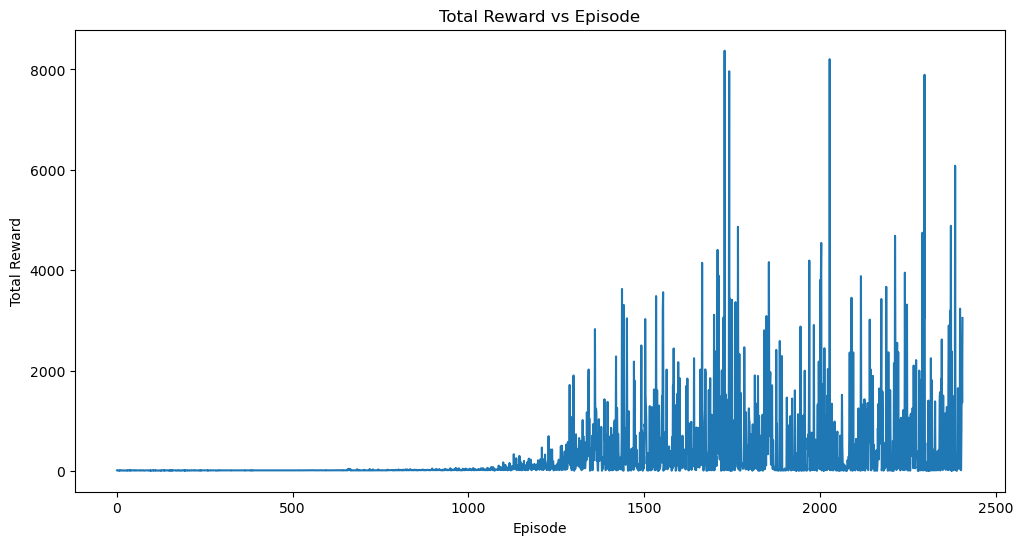

In [9]:
import gym
import flappy_bird_gym
import configparser

# 创建ConfigParser对象
config = configparser.ConfigParser()

# 添加配置项
config['Training'] = {
    'update_step_interval': '100',
    'lr': '0.0001',
    'loss_threshold' : '0.5',
    'beta': '-0.1',
    'guideopen': 'False',
    'stop_training': 'False',
    'batch_size': '512'
}

# 写入配置文件
with open('config.ini', 'w') as configfile:
    config.write(configfile)

print("配置文件已创建并写入初始内容。")
# 确保环境是 FlappyBird-v0
env = gym.make("FlappyBird-v0")
import os
import pygame

# 将声音输出重定向到"无声设备"
os.environ["SDL_AUDIODRIVER"] = "dummy"  # 设置虚拟音频驱动
pygame.mixer.quit()  # 重新初始化以应用设置

# 定义支持点范围
v_min = -1.0
v_max = 11.5
atoms = 51

# 训练网络
q_net, rewards = train_dueling_dqn_noise_MultiStep_PER(
    env,
    num_episodes=50000,
    batch_size=512,
    gamma=0.99,
    epsilon_schedule=[(0, 0), (20000, 1), (50000, 0.01), (150000, 0.01), (250000, 0.001), (350000, 0.001), (400000, 0.0001), (500000, 0.0)],
    lr=1e-4,
    alpha=0.6,
    beta_start=0.4,
    beta_increment=1e-4,
    modelFile=None,
)
plot_dataList(rewards)
env.close()